### Import libraries

In [1]:
from PIL import Image
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow import concat
import os

%matplotlib inline

### Import train data

In [2]:
%%time
# Копирование данных из гугл диска чтобы выгрузка картирнок была быстрее
!cp /content/drive/MyDrive/Cup/avia-train.zip /content/

CPU times: user 15.1 ms, sys: 14.9 ms, total: 30 ms
Wall time: 1.14 s


In [ ]:
#@title  
%%time
if os.path.exists('avia-train'):
    for i in os.listdir('/content/avia-train'):
        os.remove('/content/avia-train/' + i)
!unzip /content/avia-train.zip -d /content/

In [4]:
train = pd.read_csv('/content/drive/MyDrive/Cup/train.csv')
train.head()

,sign,filename
0,0,200d8766-4240-44d1-a2da-65dc4ee7973a
1,0,87174854-b7b6-4cb2-8183-4ca2bbd26b9d
2,0,c089638e-b683-436a-a3a3-3e5be972c4f6
3,1,8790e76c-f485-49a6-abaf-3147436ca085
4,0,c06b01db-8934-4c72-b568-508a32c4b170


In [5]:
path = '/content/avia-train/'
files = path + np.array(train.filename) + '.png'
y = np.eye(2)[train.sign]
y.shape

(31080, 2)

In [6]:
%%time
X = np.zeros((files.shape[0], 20, 20, 1))
for ind, i in enumerate(files):
    im = np.array(Image.open(i, mode='r').convert('L'))
    X[ind, :, :, 0] = im
    # X[ind] = StandardScaler().fit_transform(im.flatten()[:, None]).reshape(20, 20, 1)
    if ind % 3000 == 0:
        print(ind)

0
3000
6000
9000
12000
15000
18000
21000
24000
27000
30000
CPU times: user 4.93 s, sys: 646 ms, total: 5.57 s
Wall time: 6.26 s


In [7]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

                                          Images with Planes                                          


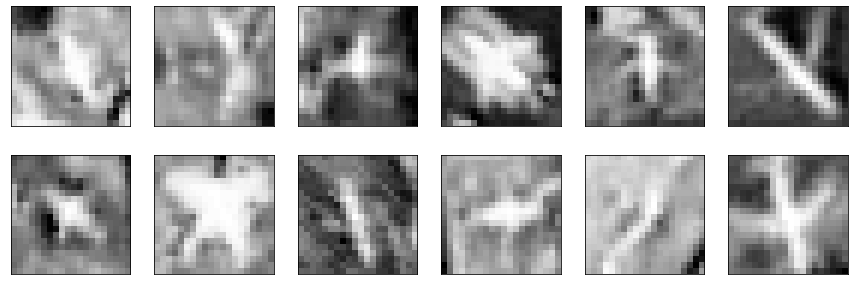

In [8]:
print((color.BOLD + 'Images with Planes' + color.END).center(110))
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (15, 5))
indexs = np.where( y[:, 1] == 1 )[0]
k = 0
for row in axes:
    for item in row:
        item.set(xticks = [], yticks = [])
        item.imshow(X[indexs[k], ..., 0], cmap = 'gray')
        k += 1

                                        Images with no Planes                                         


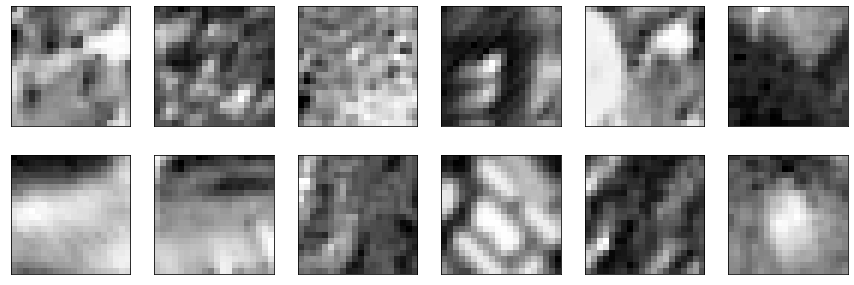

In [9]:
print((color.BOLD + 'Images with no Planes' + color.END).center(110))
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (15, 5))
indexs = np.where( y[:, 1] == 0 )[0]
k = 0
for row in axes:
    for item in row:
        item.set(xticks = [], yticks = [])
        item.imshow(X[indexs[k], ..., 0], cmap = 'gray')
        k += 1
        

### Import test data

In [10]:
%%time
!cp /content/drive/MyDrive/Cup/avia-test.zip /content/
!cp /content/drive/MyDrive/Cup/avia-test-extended.zip /content/

CPU times: user 29.5 ms, sys: 30 ms, total: 59.4 ms
Wall time: 1.59 s


In [ ]:
%%time
!unzip /content/avia-test.zip -d /content/
!unzip /content/avia-test-extended.zip -d /content/

In [12]:
test =  pd.read_csv('/content/drive/MyDrive/Cup/test_extended.csv')
test

,filename
0,68f33844-472b-4111-b600-f90d544833c7
1,7d93a21d-1f16-49ce-8fcc-edf12c40f549
2,4a820650-7acd-489a-ad14-9d7ad8c73b6b
3,819b216b-2b6c-4539-a722-70648c0706c6
4,45f7c47d-03cc-40cd-acc5-b8c1c57872fa
...,...
100995,82aba9fd-3f78-4087-99f6-af9f5a990677
100996,3bb91d2b-53fb-42d4-a644-7e30a39572cd
100997,fba3e0de-d8b7-4721-82ae-f6ff135bd746
100998,09fa231e-6998-4904-acd7-2ed71408296e


In [13]:
path1 = '/content/avia-test/'
path2 = '/content/avia-test-extended/'
test1 = test.filename[:1000]
test2 = test.filename[1000:]

In [ ]:
files = np.array([path1 + i + '.png' for i in test1] + [path2 + i + '.jpeg' for i in test2])

In [ ]:
%%time
X_test = np.zeros((files.shape[0], 20, 20, 1))
for ind, i in enumerate(files):
    im = np.array(Image.open(i, mode='r').convert('L'))
    X_test[ind, :, :, 0] = im
    # X_test[ind] = StandardScaler().fit_transform(im.flatten()[:, None]).reshape(20, 20, 1)
    if ind % 5000 == 0:
        print(ind)

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
100000
CPU times: user 12.1 s, sys: 1.48 s, total: 13.6 s
Wall time: 13.6 s


#### Show images

In [ ]:
files[:10]

array(['/content/avia-test/68f33844-472b-4111-b600-f90d544833c7.png',
       '/content/avia-test/7d93a21d-1f16-49ce-8fcc-edf12c40f549.png',
       '/content/avia-test/4a820650-7acd-489a-ad14-9d7ad8c73b6b.png',
       '/content/avia-test/819b216b-2b6c-4539-a722-70648c0706c6.png',
       '/content/avia-test/45f7c47d-03cc-40cd-acc5-b8c1c57872fa.png',
       '/content/avia-test/6c6ab487-e2cc-4cfa-9b76-6d91ddb28d9b.png',
       '/content/avia-test/991a4e12-7aa1-4f2f-8baa-beef3c42a248.png',
       '/content/avia-test/73391958-6b88-40a5-9191-5386b7925b40.png',
       '/content/avia-test/ce486f97-c0e8-421e-93d4-6470383db116.png',
       '/content/avia-test/fa83034a-1ba8-48ee-a040-342e4cd6fe65.png'],
      dtype='<U69')

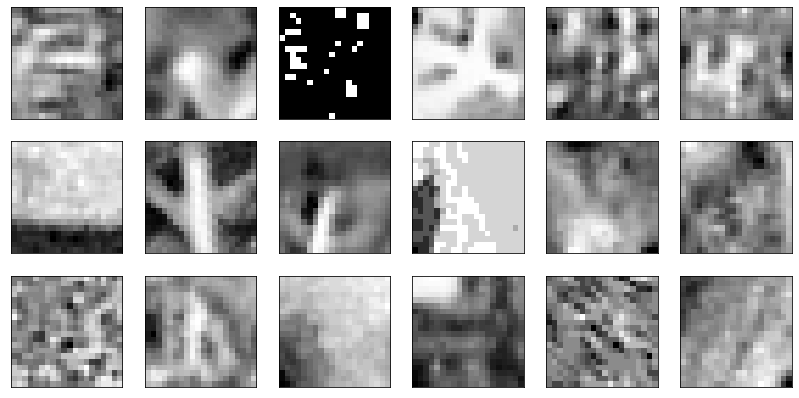

In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 6, figsize = (14, 7))
k = 0
for row in axes:
    for item in row:
        item.set(xticks = [], yticks = [])
        item.imshow(X_test[k, ..., 0], cmap = 'gray')
        k += 1


### Create Train/Test Generator

In [ ]:
train_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rotation_range=45,
    width_shift_range=0,
    height_shift_range=0,
    fill_mode="nearest",
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1./255,
    data_format='channels_last',
    validation_split=0.15
)

train_dg = train_datagen.flow(
    X, y,
    batch_size=20,
    shuffle=True,
    subset='training',
)

valid_dg = train_datagen.flow(
    X, y,
    batch_size=20,
    shuffle=True,
    subset='validation',
)
train_final_dg = train_datagen.flow(X, y,
    batch_size=20,
    shuffle=True)
del X, y

In [ ]:
test_datagen = ImageDataGenerator(
    samplewise_center=True,
    samplewise_std_normalization=True,
    zca_whitening=False,
    rescale=1./255,
    data_format='channels_last'
)

test_dg = test_datagen.flow(X_test, batch_size=1, shuffle = False)
del X_test

### Create Model

In [ ]:
if 'model' in locals():
    del model

In [ ]:
def build_model():
    input = Input((20, 20, 1), name='Input')
    out = Conv2D(100, (3, 3), padding='same', activation = 'relu', name = 'Conv11')(input)
    out = Conv2D(100, (3, 3), padding='same', activation = 'relu', name = 'Conv12')(out)
    out1 = MaxPool2D((2, 2), name = 'Maxpool_1')(out)
    out = Conv2D(200, (3, 3), padding='same', activation = 'relu', name = 'Conv21')(out1)
    out = Conv2D(200, (3, 3), padding='same', activation = 'relu', name = 'Conv22')(out)
    out = concat([out1, out], axis = 3)
    out2 = MaxPool2D((2, 2), name = 'Maxpool_2')(out)
    out = Conv2D(400, (3, 3), padding='same', activation = 'relu', name = 'Conv31')(out2)
    out = Conv2D(400, (3, 3), padding='same', activation = 'relu', name = 'Conv32')(out)
    out = concat([out2, out], axis = 3)
    out3 = MaxPool2D((2, 2), name = 'Maxpool_3')(out)
    out = Conv2D(800, (3, 3), padding='same', activation = 'relu', name = 'Conv41')(out3)
    out = Conv2D(800, (3, 3), padding='same', activation = 'relu', name = 'Conv42')(out)
    out = concat([out3, out], axis = 3)
    out = GlobalAveragePooling2D(name = 'Avarage')(out)
    out = Dense(2000, activation = 'relu', name = 'Dense1')(out)
    out = Dropout(0.4, name = 'Dropout_1')(out)
    out = Dense(1000, activation = 'relu', name = 'Dense2')(out)
    out = Dropout(0.2, name = 'Dropout_2')(out)
    out = Dense(2, activation='softmax', name = 'Output')(out)
    return Model(inputs=input, outputs=out, name = 'model')

model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
Conv11 (Conv2D)                 (None, 20, 20, 100)  1000        Input[0][0]                      
__________________________________________________________________________________________________
Conv12 (Conv2D)                 (None, 20, 20, 100)  90100       Conv11[0][0]                     
__________________________________________________________________________________________________
Maxpool_1 (MaxPooling2D)        (None, 10, 10, 100)  0           Conv12[0][0]                     
______________________________________________________________________________________________

In [ ]:
def compile_model():
    loss = BinaryCrossentropy()
    optim = Adam()
    auc = AUC(name='auc')
    model.compile(optimizer=optim, loss = loss, metrics = [auc])
compile_model()

In [ ]:
hist = model.fit(
    train_dg,
    steps_per_epoch=800,
    epochs=50,
    verbose=1,
    callbacks=None,
    validation_data=valid_dg,
    validation_steps=233,
    class_weight=None,
    use_multiprocessing=True,
    shuffle=True,
    initial_epoch=0
)

Epoch 1/50
800/800 [==============================] - 61s 34ms/step - loss: 0.2449 - auc: 0.9610 - val_loss: 0.2182 - val_auc: 0.9698
Epoch 2/50
800/800 [==============================] - 27s 34ms/step - loss: 0.1534 - auc: 0.9815 - val_loss: 0.1630 - val_auc: 0.9825
Epoch 3/50
800/800 [==============================] - 27s 34ms/step - loss: 0.1561 - auc: 0.9832 - val_loss: 0.1591 - val_auc: 0.9816
Epoch 4/50
800/800 [==============================] - 27s 34ms/step - loss: 0.1245 - auc: 0.9864 - val_loss: 0.1314 - val_auc: 0.9817
Epoch 5/50
800/800 [==============================] - 27s 34ms/step - loss: 0.1223 - auc: 0.9883 - val_loss: 0.1730 - val_auc: 0.9761
Epoch 6/50
800/800 [==============================] - 27s 33ms/step - loss: 0.1030 - auc: 0.9895 - val_loss: 0.1102 - val_auc: 0.9872
Epoch 7/50
800/800 [==============================] - 27s 34ms/step - loss: 0.0939 - auc: 0.9909 - val_loss: 0.1534 - val_auc: 0.9828
Epoch 8/50
800/800 [==============================] - 27s 34ms

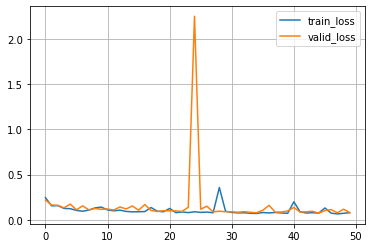

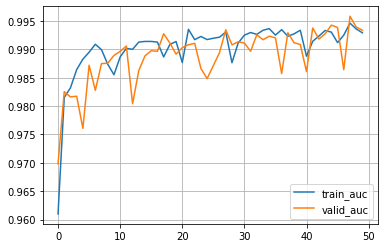

In [ ]:
plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='valid_loss')
plt.legend()
plt.grid()
plt.show()
plt.plot(hist.history['auc'], label='train_auc')
plt.plot(hist.history['val_auc'], label='valid_auc')
plt.legend()
plt.grid()
plt.show() 

### Create Submission

In [ ]:
if 'model' in locals():
    del model
model = build_model()
compile_model()

In [ ]:
model.fit(
    train_final_dg,
    steps_per_epoch=800,
    use_multiprocessing=True,
    epochs=30,
)

Epoch 1/30
800/800 [==============================] - 26s 31ms/step - loss: 0.2469 - auc: 0.9594
Epoch 2/30
800/800 [==============================] - 24s 30ms/step - loss: 0.1562 - auc: 0.9818
Epoch 3/30
800/800 [==============================] - 25s 31ms/step - loss: 0.1336 - auc: 0.9850
Epoch 4/30
800/800 [==============================] - 24s 30ms/step - loss: 0.1254 - auc: 0.9872
Epoch 5/30
800/800 [==============================] - 25s 31ms/step - loss: 0.1155 - auc: 0.9873
Epoch 6/30
800/800 [==============================] - 25s 31ms/step - loss: 0.1091 - auc: 0.9890
Epoch 7/30
800/800 [==============================] - 25s 31ms/step - loss: 0.1118 - auc: 0.9882
Epoch 8/30
800/800 [==============================] - 24s 30ms/step - loss: 0.0975 - auc: 0.9897
Epoch 9/30
800/800 [==============================] - 24s 30ms/step - loss: 0.0975 - auc: 0.9904
Epoch 10/30
800/800 [==============================] - 24s 30ms/step - loss: 0.0906 - auc: 0.9910
Epoch 11/30
800/800 [========

In [ ]:
y_pred = model.predict(test_dg)

In [ ]:
test['sign'] = y_pred[:, 1]
test

In [ ]:
test[['sign', 'filename']].to_csv('/content/drive/MyDrive/Cup/submission.csv', index=False)

## Score: 99.8